comes from: https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# set env for colab

In [0]:
!apt-get -qq install -y protobuf-compiler python-pil python-lxml python-tk

In [49]:
!pip install --user contextlib2 Cython lxml

In [50]:
!git clone https://github.com/cocodataset/cocoapi.git

fatal: destination path 'cocoapi' already exists and is not an empty directory.


In [51]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [52]:
%cd /content/cocoapi/PythonAPI

/content/cocoapi/PythonAPI


In [53]:
!make

python setup.py build_ext --inplace
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-2.7
creating build/temp.linux-x86_64-2.7/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -fno-strict-aliasing -Wdate-time -D_FORTIFY_SOURCE=2 -g -fdebug-prefix-map=/build/python2.7-nbjU53/python2.7-2.7.15~rc1=. -fstack-protector-strong -Wformat -Werror=format-security -fPIC -I/usr/local/lib/python2.7/dist-packages/numpy/core/include -I../common -I/usr/include/python2.7 -c ../common/maskApi.c -o build/temp.linux-x86_64-2.7/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=!v; }}
       ^~~
../common/maskApi.c:46:49: note: .

In [54]:
%ls

Makefile  pycocoDemo.ipynb  pycocoEvalDemo.ipynb  pycocotools/  setup.py


## 确认在上一个操作中，看到了 pycocotools 目录，再进行下面的操作

In [0]:
cp -r pycocotools /content/models/research/

In [56]:
%cd /content/models/research/

/content/models/research


In [57]:
%ls object_detection/protos/

anchor_generator_pb2.py        losses_pb2.py
anchor_generator_pb2.pyc       losses_pb2.pyc
anchor_generator.proto         losses.proto
argmax_matcher_pb2.py          matcher_pb2.py
argmax_matcher_pb2.pyc         matcher_pb2.pyc
argmax_matcher.proto           matcher.proto
bipartite_matcher_pb2.py       mean_stddev_box_coder_pb2.py
bipartite_matcher_pb2.pyc      mean_stddev_box_coder_pb2.pyc
bipartite_matcher.proto        mean_stddev_box_coder.proto
box_coder_pb2.py               model_pb2.py
box_coder_pb2.pyc              model_pb2.pyc
box_coder.proto                model.proto
box_predictor_pb2.py           multiscale_anchor_generator_pb2.py
box_predictor_pb2.pyc          multiscale_anchor_generator_pb2.pyc
box_predictor.proto            multiscale_anchor_generator.proto
eval_pb2.py                    optimizer_pb2.py
eval.proto                     optimizer.proto
faster_rcnn_box_coder_pb2.py   pipeline_pb2.py
faster_rcnn_box_coder_pb2.pyc  pipeline.proto
faster_rcnn_box_coder.proto  

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [59]:
%ls object_detection/protos/

anchor_generator_pb2.py        losses_pb2.py
anchor_generator_pb2.pyc       losses_pb2.pyc
anchor_generator.proto         losses.proto
argmax_matcher_pb2.py          matcher_pb2.py
argmax_matcher_pb2.pyc         matcher_pb2.pyc
argmax_matcher.proto           matcher.proto
bipartite_matcher_pb2.py       mean_stddev_box_coder_pb2.py
bipartite_matcher_pb2.pyc      mean_stddev_box_coder_pb2.pyc
bipartite_matcher.proto        mean_stddev_box_coder.proto
box_coder_pb2.py               model_pb2.py
box_coder_pb2.pyc              model_pb2.pyc
box_coder.proto                model.proto
box_predictor_pb2.py           multiscale_anchor_generator_pb2.py
box_predictor_pb2.pyc          multiscale_anchor_generator_pb2.pyc
box_predictor.proto            multiscale_anchor_generator.proto
eval_pb2.py                    optimizer_pb2.py
eval.proto                     optimizer.proto
faster_rcnn_box_coder_pb2.py   pipeline_pb2.py
faster_rcnn_box_coder_pb2.pyc  pipeline.proto
faster_rcnn_box_coder.proto  

In [60]:
%env PYTHONPATH

'/env/python:/content/models/research/slim:/content/models/research:/content/models/research/object_detection'

In [61]:
%env PYTHONPATH=/env/python:/content/models/research/slim:/content/models/research:/content/models/research/object_detection

env: PYTHONPATH=/env/python:/content/models/research/slim:/content/models/research:/content/models/research/object_detection


In [62]:
!python object_detection/builders/model_builder_test.py

.....................
----------------------------------------------------------------------
Ran 21 tests in 0.183s

OK


# Imports

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


## Env setup

In [0]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [0]:
sys.path.append("/content/models/research/object_detection")

In [0]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [0]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/models/research/object_detection/data', 'mscoco_label_map.pbtxt')

## Download Model

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [73]:
PATH_TO_LABELS

'/content/models/research/object_detection/data/mscoco_label_map.pbtxt'

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/models/research/object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

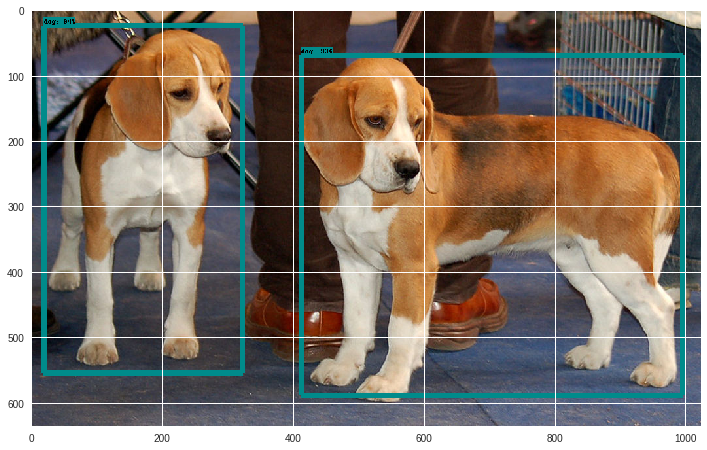

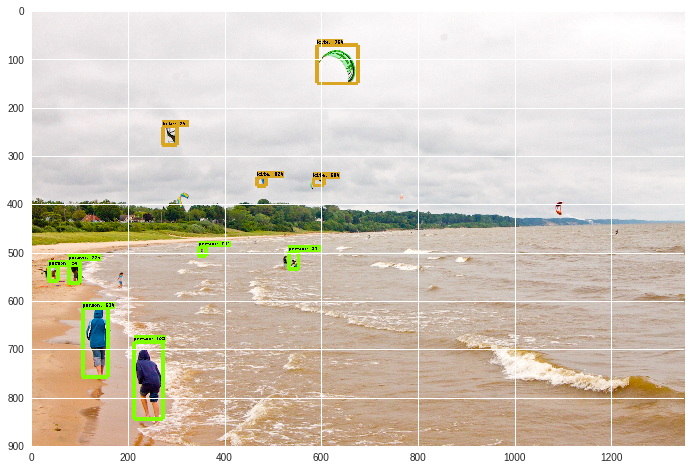

In [81]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)